# Analyzing Ithaca's Gorge Stewarding Program

##  Import and Setup

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !pip install hdbscan

In [171]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [37]:
np.random.seed(42)

In [8]:
gorges = pd.read_csv("/content/gorges.csv")
gorges = gorges.iloc[:, :-12]
gorges.loc[146, 'Date'] = "6/30/2022"
gorges.loc[215, 'Date'] = "5/28/2021"
gorges.loc[509, 'Date'] = "6/5/2019"
gorges.loc[529, 'Date'] = "6/19/2019"
gorges.loc[558, 'Date'] = "7/3/2019"
gorges.loc[589, 'Date'] = "7/17/2019"
gorges.loc[599, 'Date'] = "7/22/2019"
gorges.loc[620, 'Date'] = "7/31/2019"
gorges.loc[649, 'Date'] = "8/14/2019"
gorges.loc[669, 'Date'] = "8/28/2019"
gorges.loc[667, 'Date'] = "8/28/2019"

# convert date into a date object
gorges['Date'] = pd.to_datetime(gorges['Date'])

print(len(gorges))
gorges.head()


1107


,Date,Patrol Time,Steward name,High Temperature,Weather,Number of observed gorge users,total Number of people obseved violating a rule,Number of person interactions: Alternatives,Number of person interactions: Warnings,Number of person interactions: Directions,Total number of person interactions (Daily),Number of contacts to CUPD,Number of People above Ithaca Falls?,Description of Interactions,Description of notable events
0,2023-05-25,11AM-7PM,Brenner,61,"sunny, windy",168,0,0.0,0.0,1.0,1.0,0,0,Someone asked about north campus,saw some geese babies!
1,2023-05-26,11AM-7PM,Brenner,68,"sunny, clear",264,0,0.0,0.0,9.0,9.0,0,0,lots of commencement direction questions,numerous grad photos
2,2023-05-27,11AM-7PM,Brenner,77,sunny,251,2,0.0,2.0,5.0,7.0,0,0,few people suntanning on rocks in the water,someone asked me where the slope was lol
3,2023-05-28,11-7PM,Phillip,81,Sunny,184,5,0.0,5.0,9.0,14.0,0,0,"Lots of people looking for arboretum, three do...",I saw a cool butterfly
4,2023-05-29,11-7PM,Phillip,85,Sunny,102,0,0.0,0.0,6.0,0.0,0,0,"Big day for tourists, small day for violators",Found boathouse key on Bebee lake trail. Is no...


In [319]:
# extract out the observations column that aren't nan
interactions_df = gorges[gorges['Description of Interactions'].notna()]
interactions_df = interactions_df[interactions_df['Description of Interactions'] != '0']
interactions_df = interactions_df.iloc[:285, :]

# keep only non-na observations
observations_df = gorges[gorges['Description of notable events'].notna()]

#place all the interactions and observations into a dictionary (this is later uncased, but may be helpful)
log = {'interaction': [],'observation': []}

for i in range(len(interactions_df)):
    msg = {'index': i,
           'date': interactions_df.iloc[i, 0],
           "steward": interactions_df.iloc[i, 2],
           "msg": interactions_df.iloc[i, 13]}
    log['interaction'].append(msg)

for i in range(len(observations_df)):
    msg = {'index': i,
           'date': observations_df.iloc[i, 0],
           "steward": observations_df.iloc[i, 2],
           "msg": observations_df.iloc[i, 14]}
    log['observation'].append(msg)

# reassign dict to respective lists
interactions = log['interaction']
observations = log['observation']

print("Interactions before split:", len(interactions))

interactions_split = []

# for interaction in interactions:
#     if ',' in interaction['msg']:
#         parts = re.split(r'[.,;]', entry['msg'])

#         parts = interaction['msg'].split(', ')
#         for part in parts:
#             new_interaction = interaction.copy()
#             new_interaction['msg'] = part
#             interactions_split.append(new_interaction)
#     else:
#         interactions_split.append(interaction)

for interaction in interactions:
    parts = re.split(r'[.,;]', interaction['msg'])
    for part in parts:
        part = part.strip()
        if part:
            new_inter = interaction.copy()
            new_inter['msg'] = part
            interactions_split.append(new_inter)


for interaction in interactions:
    parts = re.split(r'[.,;]', interaction['msg'])
    for part in parts:
        part = part.strip()
        if part:
            new_inter = interaction.copy()
            new_inter['msg'] = part
            interactions_split.append(new_inter)

observations_split = []
observations_unsplit = []

for entry in observations:
    # Split the 'msg' by commas, periods, and semicolons
    parts = re.split(r'[.,;]', entry['msg'])
    for part in parts:
        # Remove leading and trailing whitespaces from each part
        part = part.strip()
        if part:
            new_entry = entry.copy()  # Create a copy of the original entry
            new_entry['msg'] = part  # Replace 'msg' with the current part
            interactions_split.append(new_entry)

interactions_unsplit = []
interactions_unsplit = interactions
interactions = interactions_split

print("Total Interactions after split:", len(interactions))
print("First three interactions:")
for i in range(3):
  print(interactions[i])
print("")

print("Total Observations:", len(log['observation']))
print('First three observation texts:')
for i in range(220, 223):
  print(observations[i]['msg'])

Interactions before split: 285
Total Interactions after split: 1561
First three interactions:
{'index': 0, 'date': Timestamp('2023-05-25 00:00:00'), 'steward': 'Brenner', 'msg': 'Someone asked about north campus'}
{'index': 1, 'date': Timestamp('2023-05-26 00:00:00'), 'steward': 'Brenner', 'msg': 'lots of commencement direction questions'}
{'index': 2, 'date': Timestamp('2023-05-27 00:00:00'), 'steward': 'Brenner', 'msg': 'few people suntanning on rocks in the water'}

Total Observations: 223
First three observation texts:
Lots's of ppl outside walking after classes let out this PM. Love to see it!
nothing notable happened today.
lots of poeple all over! great last day. Hope to continue again next summer!


## Exploratory Data Analysis and Statistics

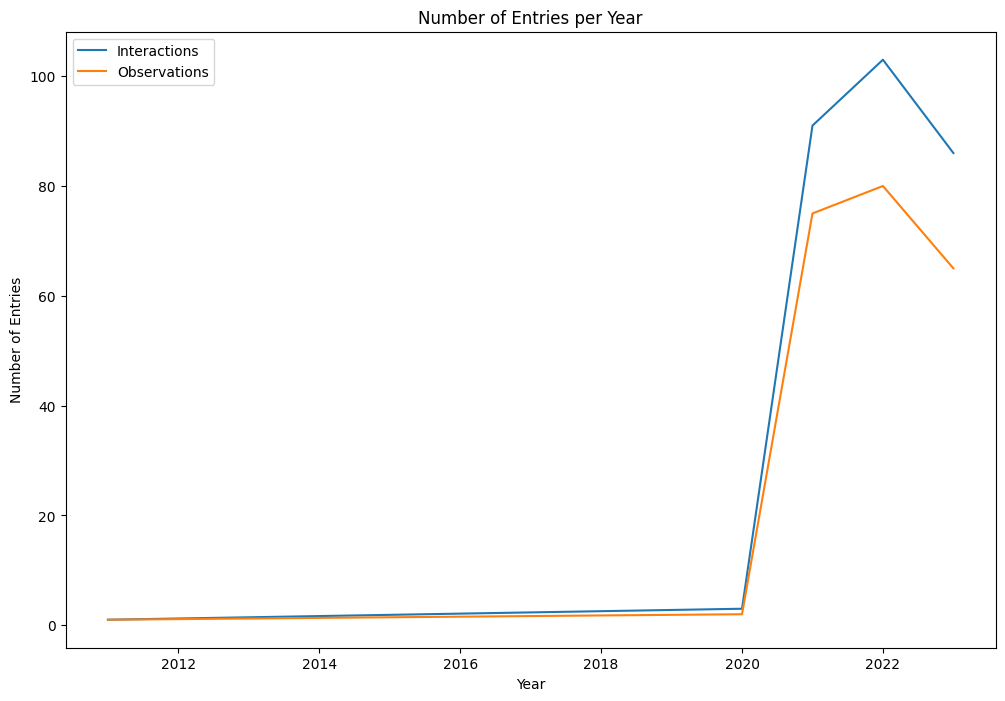

In [320]:
# amount of rows per year

num_inter = interactions_df.groupby('Date').size().groupby(lambda x: x.year).sum()
num_obsv = observations_df.groupby('Date').size().groupby(lambda x: x.year).sum()

# graph this out
plt.figure(figsize=(12, 8))
plt.plot(num_inter, label='Interactions')
plt.plot(num_obsv, label='Observations')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Year')
plt.legend()
plt.show()

In [321]:
# return 20 most frequent words, not including stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.extend(string.punctuation)
eng_stopwords.extend(['lower'])

def word_stats(data, stopwords=eng_stopwords, n=20):
    if (stopwords != None):
        for stopword in stopwords:
            del data[stopword]

    print("Number of total tokens in text:", sum(data.values()))
    print("Number of unique words in interactions:", len(data.values()))
    print("Top", n, "most frequent words in text:")
    print(data.most_common(n))

words = []
for description in interactions_df['Description of Interactions']:
    words += nltk.word_tokenize(description)
inter_counter = Counter(words)

words = []
for description in observations_df['Description of notable events']:
    words += nltk.word_tokenize(description)
obsv_counter = Counter(words)

print(word_stats(inter_counter))
print(word_stats(obsv_counter))


Number of total tokens in text: 2808
Number of unique words in interactions: 823
Top 20 most frequent words in text:
[('people', 103), ('casc', 103), ('trail', 63), ('2', 57), ('violations', 53), ('swimming', 45), ('I', 41), ('falls', 40), ('No', 37), ('one', 35), ('gorge', 35), ('asked', 33), ('leash', 33), ('today', 33), ('1', 27), ('dog', 27), ('bridge', 27), ('cascadilla', 27), ('water', 24), ('3', 23)]
None
Number of total tokens in text: 1834
Number of unique words in interactions: 923
Top 20 most frequent words in text:
[('I', 36), ('today', 28), ('people', 25), ('saw', 23), ('day', 23), ('casc', 20), ('trash', 19), ('Saw', 17), ('gorge', 17), ('notable', 14), ('trail', 13), ("n't", 13), ('got', 12), ('Beebe', 12), ('water', 12), ('nice', 12), ('lots', 11), ('many', 11), ('rain', 11), ('Nothing', 11)]
None


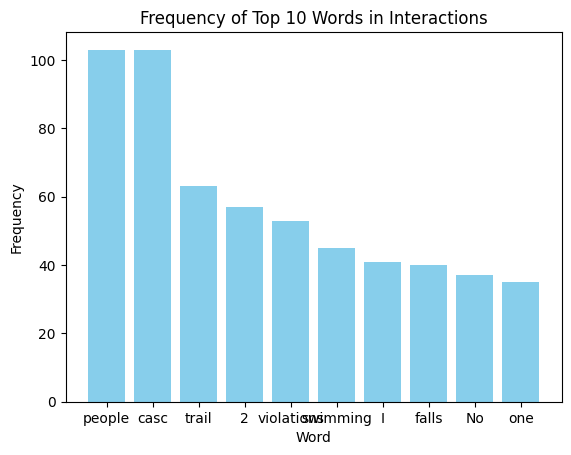

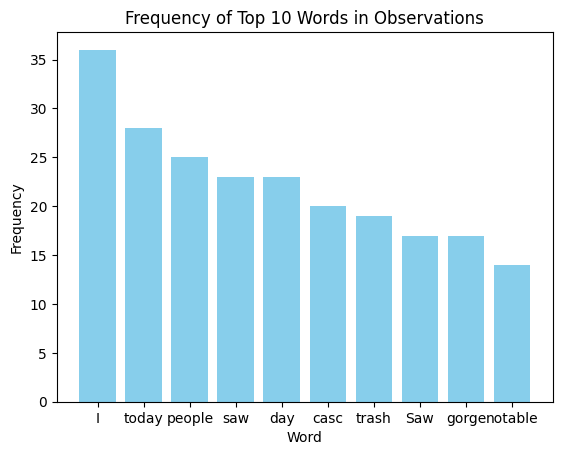

In [322]:
# visualization of the frequency of words in interactions

data = inter_counter.most_common(10)
words, values = zip(*data)
plt.bar(words, values, color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Interactions')
plt.show()

data = obsv_counter.most_common(10)
words, values = zip(*data)
plt.bar(words, values, color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Observations')
plt.show()

*Also at that cool stuff from the previous paper*


## Sentiment Analysis

#### Methods

In [323]:
# Score text sentiment
vader = SentimentIntensityAnalyzer()

# tokenizes text
def tokenize_text(text) :
    return [word_tokenize(sent.lower()) for sent in sent_tokenize(text)]

# method to return sentiment scores of a sentence
def text_sentiment(analyzer, tokens, vader_lexicon):
    sentiment_dict = analyzer.polarity_scores(' '.join(tokens))
    compound_score = sentiment_dict['compound']

    if compound_score >= 0.05:
        overall_sentiment = 'pos'
    elif compound_score <= -0.05:
        overall_sentiment = 'neg'
    else:
        overall_sentiment = 'neu'

    matched_terms = {}
    for token in tokens:
        token_lower = token.lower()
        if token_lower in vader_lexicon:
            matched_terms[token_lower] = vader_lexicon[token_lower]

    sentiment_dict['overall sentiment'] = overall_sentiment
    sentiment_dict['matched terms'] = matched_terms

    return sentiment_dict

def print_sentiment(sentiments_list):
  print("Total sentences:", len(sentiments_list))
  print("Total positive sentences:", sum([sent['overall sentiment'] == 'neg' for sent in sentiments_list]))
  print("Total neutral sentences:", sum([sent['overall sentiment'] == 'neu' for sent in sentiments_list]))
  print("Total negative sentences:", sum([sent['overall sentiment'] == 'pos' for sent in sentiments_list]))
  print("Average sentiment:", sum([sent['compound'] for sent in inter_sentiment]) / len(sentiments_list))

#### Interactions

In [324]:
# create a list of tokenized interactions
inter_tokens = []

for interaction in interactions:
  inter_tokens.extend(tokenize_text(interaction['msg']))

print(inter_tokens)
# we remove "lower" as it has a negative sentiment score and biased the overall sentiment
# inter_tokens = [(filter(lambda x: x != "lower", sentence)) for sentence in inter_tokens]
# We also remove empty messages
# inter_tokens = [list(filter(lambda x: x != "", sentence)) for sentence in inter_tokens]

inter_sentiment = [text_sentiment(vader, tokens, vader.lexicon) for tokens in inter_tokens]

print_sentiment(inter_sentiment)

print("\nSentences with three or more matched terms:")
# print the most matched terms
for sent in inter_sentiment:
    if len(sent['matched terms']) > 2:
        print(sent['overall sentiment'])
        print(sent['matched terms'])
        print('---')

[['someone', 'asked', 'about', 'north', 'campus'], ['lots', 'of', 'commencement', 'direction', 'questions'], ['few', 'people', 'suntanning', 'on', 'rocks', 'in', 'the', 'water'], ['lots', 'of', 'people', 'looking', 'for', 'arboretum'], ['three', 'dogs', 'off', 'leash', 'on', 'bebee', 'lake', 'trail', 'and', 'cascadilla', 'trail'], ['2', 'people', 'past', 'trail', 'in', 'hemlock', 'gorge'], ['big', 'day', 'for', 'tourists'], ['small', 'day', 'for', 'violators'], ['1', 'dog', 'off', 'leash', 'on', 'upper', 'casc'], ['four', 'guys', 'taking', 'photos', 'in', 'lower', 'casc'], ['people', 'standing', 'in', 'the', 'water', 'near', 'falls'], ['people', 'on', 'other', 'side', 'of', 'fence'], ['people', 'sitting', 'in', 'water', 'near', 'falls'], ['not', 'many', 'people', 'put', 'and', 'about', 'today'], ['people', 'trying', 'to', 'swim', 'in', 'the', 'base', 'of', 'ithaca', 'falls', 'area'], ['child', 'leaning', 'over', 'the', 'edge', 'of', 'that', 'pool', 'part'], ['guy', 'fishing', 'at', 'en

#### Observations

In [186]:
# create a list of tokenized observations
obsv_tokens = []
for observation in observations:
  obsv_tokens.extend(tokenize_text(observation['msg']))

# # we remove "lower" as it has a negative sentiment score and biased the overall sentiment
# obsv_tokens = [list(filter(lambda x: x != "lower", sentence)) for sentence in obsv_tokens]
# # We also remove empty messages
# obsv_tokens = [list(filter(lambda x: x != "", sentence)) for sentence in obsv_tokens]

obsv_sentiment = [text_sentiment(vader, token, vader.lexicon) for token in obsv_tokens]

print_sentiment(obsv_sentiment)

print("\nSentences with three or more matched terms:")
# print the most matched terms
for sent in obsv_sentiment:
    if len(sent['matched terms']) > 2:
        print(sent['overall sentiment'])
        print(sent['matched terms'])
        print('---')

Total sentences: 324
Total positive sentences: 40
Total neutral sentences: 211
Total negative sentences: 73
Average sentiment: -0.06718086419753103

Sentences with three or more matched terms:
neg
{'trouble': -1.7, 'violently': -2.8, 'threatened': -2.0}
---
pos
{'violations': -2.4, 'good': 1.9, 'nice': 1.8}
---
neg
{'surprised': 0.9, 'no': -1.2, 'violations': -2.4, 'number': 0.3, 'cool': 1.3}
---
pos
{'like': 1.5, 'great': 3.1, 'heron': 0.1}
---
pos
{'freaked': -1.2, 'hope': 1.9, 'okay': 0.9}
---
pos
{'nice': 1.8, 'great': 3.1, 'rainy': -0.3}
---
pos
{'love': 3.2, 'easily': 1.4, 'violators': -1.9}
---
pos
{'super': 2.9, 'rainy': -0.3, 'nice': 1.8, 'cool': 1.3}
---
pos
{'dead': -3.3, 'heroes': 2.3, 'save': 2.2}
---


#### Sentiment of Interactions Over The Years

In [190]:
inter_sent_date = []
for sent in interactions:
  token_sent = tokenize_text(sent['msg'])
  token_sent = (map(str, token_sent))
  token_sent = ' '.join(token_sent)

  sentiment = text_sentiment(vader, token_sent, vader.lexicon)
  content = {
      'date': sent['date'],
      'sentiment': sentiment
  }
  inter_sent_date.append(content)

inter_sent_date = pd.DataFrame(inter_sent_date)
inter_sent_date.date = pd.to_datetime(inter_sent_date.date).dt.year

# Calculate the average sentiment of interactions for each year
for key, group in inter_sent_date.groupby(inter_sent_date.date):
  print("Year", key)
  print_sentiment(group['sentiment'])
  print("---")

Year 2011.0
Total sentences: 6
Total positive sentences: 0
Total neutral sentences: 6
Total negative sentences: 0
Average sentiment: -3.6277666666666755
---
Year 2015.0
Total sentences: 44
Total positive sentences: 0
Total neutral sentences: 44
Total negative sentences: 0
Average sentiment: -0.49469545454545577
---
Year 2016.0
Total sentences: 6
Total positive sentences: 0
Total neutral sentences: 6
Total negative sentences: 0
Average sentiment: -3.6277666666666755
---
Year 2017.0
Total sentences: 1
Total positive sentences: 0
Total neutral sentences: 1
Total negative sentences: 0
Average sentiment: -21.766600000000054
---
Year 2019.0
Total sentences: 6
Total positive sentences: 0
Total neutral sentences: 6
Total negative sentences: 0
Average sentiment: -3.6277666666666755
---
Year 2020.0
Total sentences: 110
Total positive sentences: 0
Total neutral sentences: 110
Total negative sentences: 0
Average sentiment: -0.1978781818181823
---
Year 2021.0
Total sentences: 321
Total positive sen

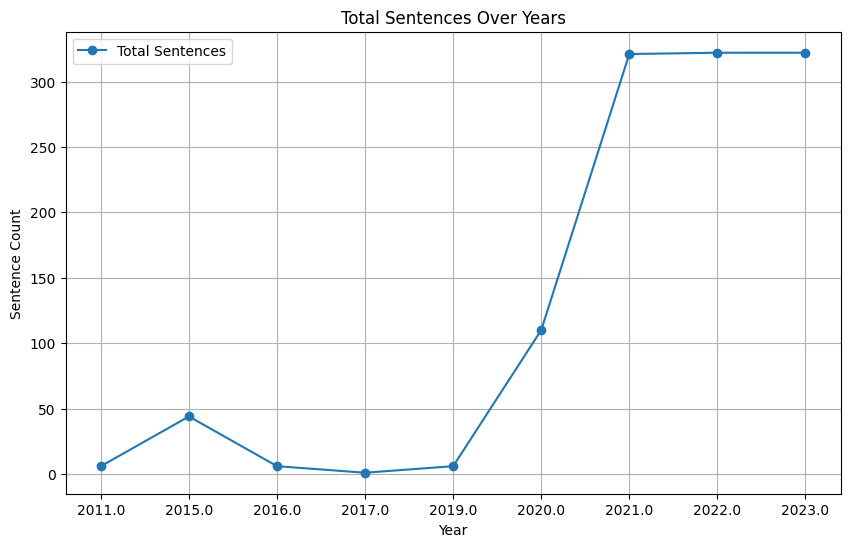

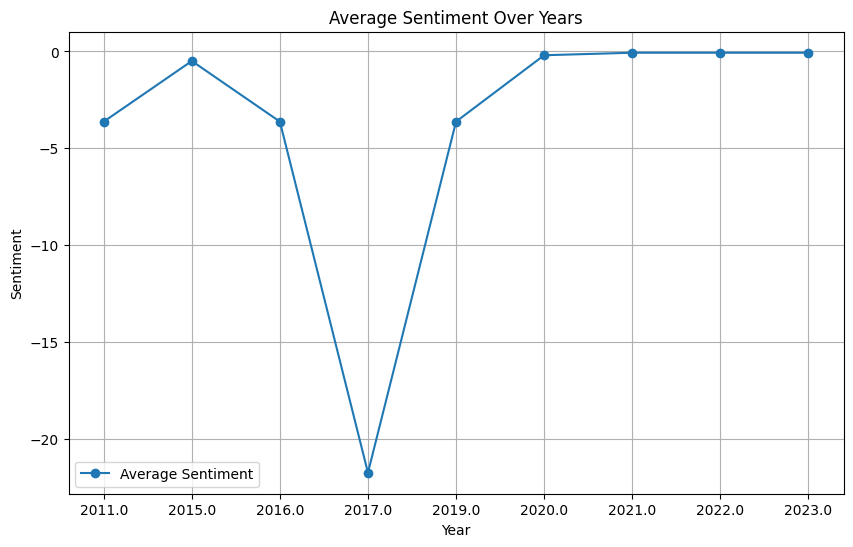

In [198]:
sent_year_output = """Year 2011.0 - Total sentences: 6 - Average sentiment: -3.6277666666666755
Year 2015.0 - Total sentences: 44 - Average sentiment: -0.49469545454545577
Year 2016.0 - Total sentences: 6 - Average sentiment: -3.6277666666666755
Year 2017.0 - Total sentences: 1 - Average sentiment: -21.766600000000054
Year 2019.0 - Total sentences: 6 - Average sentiment: -3.6277666666666755
Year 2020.0 - Total sentences: 110 - Average sentiment: -0.1978781818181823
Year 2021.0 - Total sentences: 321 - Average sentiment: -0.0678087227414332
Year 2022.0 - Total sentences: 322 - Average sentiment: -0.0675981366459629
Year 2023.0 - Total sentences: 322 - Average sentiment: -0.0675981366459629"""




# Extracting data
years = re.findall(r'Year (\d+\.\d+)', sent_year_output)
total_sentences = list(map(int, re.findall(r'Total sentences: (\d+)', sent_year_output)))
average_sentiments = list(map(float, re.findall(r'Average sentiment: (-?\d+\.\d+)', sent_year_output)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, total_sentences, label='Total Sentences', marker='o')
plt.xlabel('Year')
plt.ylabel('Sentence Count')
plt.title('Total Sentences Over Years')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, average_sentiments, label='Average Sentiment', marker='o')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('Average Sentiment Over Years')
plt.legend()
plt.grid(True)
plt.show()

In [163]:
# obsv_sent_date = []

# for sent in observations:
#   token_sent = tokenize_text(sent['msg'])
#   token_sent = (map(str, token_sent))
#   token_sent = ' '.join(token_sent)

#   sentiment = text_sentiment(vader, token_sent, vader.lexicon)
#   content = {
#       'date': sent['date'],
#       'sentiment': sentiment
#   }
#   obsv_sent_date.append(content)

#   obsv_sent_date = pd.DataFrame(obsv_sent_date)
#   obsv_sent_date.date = pd.to_datetime(obsv_sent_date.date).dt.year

#   # Calculate the average sentiment of interactions for each year
#   for key, group in obsv_sent_date.groupby(obsv_sent_date.date):
#     print("Year", key)
#     print_sentiment(group['sentiment'])
#     print("---")




## Euclidean Differences

In [188]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', norm='l2', use_idf=False)

# extract out only the messages of log
inter_obsv_tokens = [inter_tokens, obsv_tokens]

# features = vectorizer.fit_transform(inter_obsv_tokens)
features = tfidf_vectorizer.fit_transform([str(x) for x in inter_obsv_tokens])


print('Matrix shape:', features.shape)
# print('Feature labels:', vectorizer.get_feature_names_out())
# print('Stopwords used:', vectorizer.stop_words_, '\n')
# print('First line vector:', features[0].toarray(), '\n')

# print('Unique words:', list(set(log[0].split())))

euclidean_dist = euclidean_distances(features)
cosine_dist = cosine_distances(features)

print("\nEuclidean Distances (Normalized, TF-IDF):")
print(euclidean_dist)
print("\nCosine Distances (Normalized, TF-IDF):")
print(cosine_dist)



Matrix shape: (2, 1396)

Euclidean Distances (Normalized, TF-IDF):
[[0.         0.66759206]
 [0.66759206 0.        ]]

Cosine Distances (Normalized, TF-IDF):
[[0.         0.22283958]
 [0.22283958 0.        ]]


Matrix Shape:

The TF-IDF matrix has a shape of (2, 1396), indicating that there are 2 documents and 1396 features (likely unique terms or words after processing the text data).
Euclidean Distances (Normalized, TF-IDF):

This matrix shows the normalized Euclidean distances between pairs of documents.
The values in the matrix represent how "far apart" the documents are in the multi-dimensional space of the TF-IDF features.
The diagonal elements are zero, as each document is identical to itself.
The off-diagonal elements indicate the normalized Euclidean distances between the two documents.
In this case, the Euclidean distance between the two documents is 0.52700126.
Cosine Distances (Normalized, TF-IDF):

This matrix displays the normalized cosine distances between pairs of documents.
The values in the matrix represent how dissimilar the documents are based on cosine similarity (1 - cosine similarity).
The diagonal elements are zero, as each document is perfectly similar to itself.
The off-diagonal elements indicate the normalized cosine distances between the two documents.
In this case, the cosine distance between the two documents is 0.13886516.
Interpretation:

A lower value in the Euclidean Distances matrix and a higher value in the Cosine Distances matrix suggest that the two documents are more similar.
The specific values themselves are relative, and their interpretation may depend on the range of values typically observed in your dataset.
The Euclidean distance is generally small, indicating proximity in the TF-IDF feature space.
The Cosine distance is also small, suggesting high similarity between the two documents.
In summary, these results indicate that the two documents are close in both Euclidean and cosine distances, signifying a high degree of similarity based on their TF-IDF representations.

In [19]:
steward_log = inter_tokens
stweard_log = steward_log.extend(obsv_tokens)

print(len(steward_log))

print(steward_log[1])


824
['lots', 'of', 'commencement', 'direction', 'questions']


## Unsupervised Clustering Labelling Types of Interactions




In [199]:
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=2)
        X_reduced = svd.fit_transform(X)
    else:
        X_reduced = X

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=alpha)
    ax1.set_title('Unclustered Data')

    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=alpha)
    ax2.set_title('Clustered Data')

    fig.suptitle(title)

    plt.show()

    # Pull sample texts from each label set
def pull_samples(texts, labels, n=3):
    unique_labels = np.unique(labels)

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]

        print("Label:", label)
        print("Number of texts in this cluster:", len(label_indices))

        if len(label_indices) == 0:
            print("No texts in this cluster.")
        else:
            sampled_indices = np.random.choice(label_indices, size=min(n, len(label_indices)), replace=False)

            for i, index in enumerate(sampled_indices):
                print('\033[1m' + "Sample text", i + 1, "(Index:", index, "):" + '\033[0m', texts[index])

        print("----------------------------")

### Interactions

#### K-Means

Shape of clustered interactions: (285,)


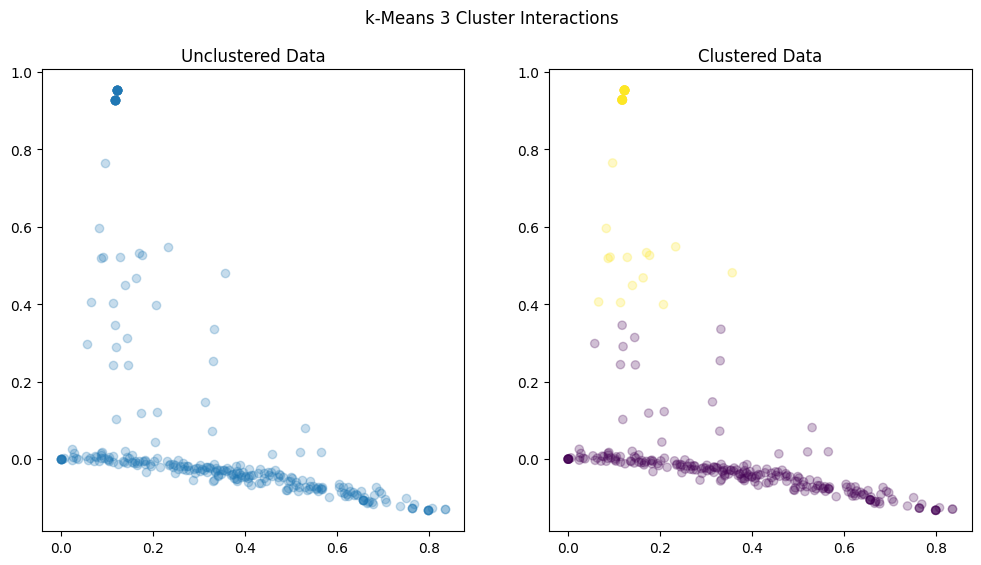

Label: 0
Number of texts in this cluster: 237
Sample text 1 (Index: 103 ): All minor instances of off trail, mostly in casc, 1 in fall creek where the guy was confused about the map he'd seen
Sample text 2 (Index: 83 ): Lots of people sitting on rocks in cascidilla, just advised them that it was dangerous and they should move
Sample text 3 (Index: 61 ): everyone loves that rock in casc
Sample text 4 (Index: 167 ): 3 dogs off leash, all others off trail in casc
Sample text 5 (Index: 38 ): asked guy reading on rocks past fence in casc to move
Sample text 6 (Index: 31 ): 2 people outside of casc fenced area warned, 1 family swimming in casc given alternative swim locations, gave directions to the same 2 people multiple times throughout my shift and gave my opinion on the best trails/views
Sample text 7 (Index: 90 ): 2 people with a tripod taking photos in the water at cascadilla under big waterfall, one guy playing ukulele on the rocks of upper casc by the water
Sample text 8 (Index: 129 

In [325]:
# k-Means clustering with n_clusters = 2
inter = []
for interaction in interactions_unsplit:
  inter.append(interaction['msg'])

inter_tokens = tfidf_vectorizer.fit_transform(inter)


inter_pred_2 = KMeans(n_clusters=2, n_init='auto').fit_predict(inter_tokens)
print("Shape of clustered interactions:", inter_pred_2.shape)
plot_compare(inter_tokens, inter_pred_2, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(inter, inter_pred_2, 10)

Cluster 1: No violations
Cluster 2: Yes Violations

Shape of clustered interactions: (285,)


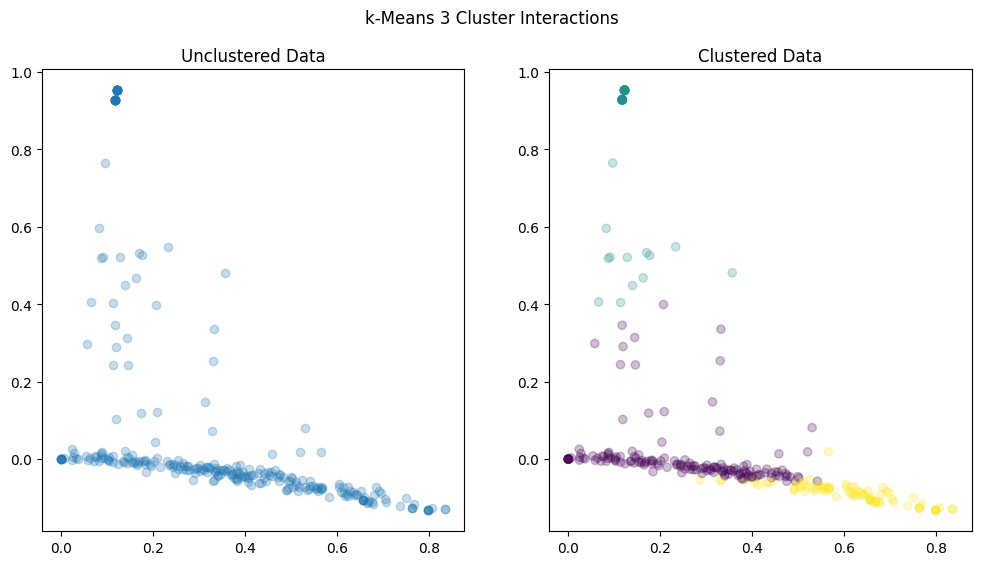

Label: 0
Number of texts in this cluster: 156
Sample text 1 (Index: 284 ): Emailed Mike: Chain link section missing from Horeshoe Falls overlook, people have created a path to the waterfall.
Sample text 2 (Index: 120 ): howdeedo all the way
Sample text 3 (Index: 277 ): A group of 4 swimming in Risley gorge
Sample text 4 (Index: 10 ): 1st interaction to give directions, 2nd interaction was to take a picture for a group
Sample text 5 (Index: 249 ): 2 friends swimming in hemlock gorge area (on 2 separate occasions); 2 people laying on the ground near water below suspension bridge. Explained to a family that Cascadilla was still closed
Sample text 6 (Index: 202 ): 1 person in cascadilla, 1 person on the falls above the tennis courts
Sample text 7 (Index: 112 ): many prospective students and visitors; told story of how girl fell into cascadilla but landed on racoon and both she and racoon lived sometime in the 80s
Sample text 8 (Index: 171 ): "howdeedo!" lots of families & prospective stude

In [334]:
# k-Means clustering with n_clusters = 3
inter = []
for interaction in interactions_unsplit:
  inter.append(interaction['msg'])

inter_vectors = tfidf_vectorizer.fit_transform(inter)


inter_pred_3 = KMeans(n_clusters=3, n_init='auto', random_state=123).fit_predict(inter_vectors)
print("Shape of clustered interactions:", inter_pred_3.shape)
plot_compare(inter_tokens, inter_pred_3, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(inter, inter_pred_3, 15)

Cluster 1: Violation
Cluster 2: No violation
CLuster 3: Cascidilla-related violation


#### Spectral Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral Clustering Labels Shape: (354,)


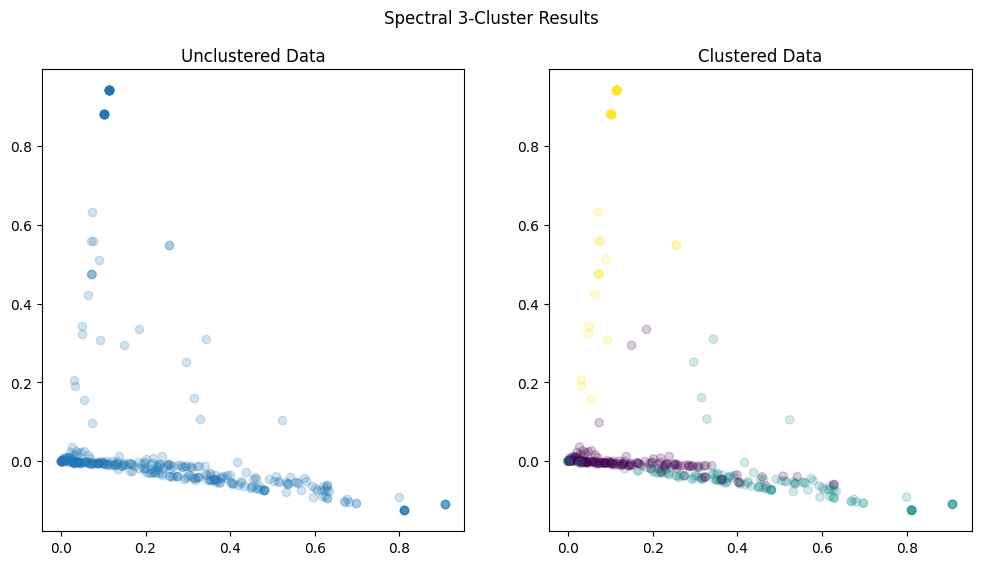

Label: 0
Number of texts in this cluster: 164
Sample text 1 (Index: 203 ): One woman in Hemlock gorge falls area, plus dog off leash
Sample text 2 (Index: 81 ): More and more directions, lots of peopel around bb lake looking for dorms and what not
Sample text 3 (Index: 284 ): Emailed Mike: Chain link section missing from Horeshoe Falls overlook, people have created a path to the waterfall.
Sample text 4 (Index: 332 ): Beaver spotting in SE corner of Beebe Lake
Sample text 5 (Index: 294 ): witnessed huge rockfall on lower cascadilla near the middle bridge. goat path further undercut
Sample text 6 (Index: 317 ): FC113- chain disconnected, connector is missing
Sample text 7 (Index: 116 ): Gave some directions to a couple walking around beebe lake looking for the wildflower garden
Sample text 8 (Index: 210 ): Family of five past the signs in upper Hemlock Gorge
Sample text 9 (Index: 314 ): Stone bench broken near fc113
Sample text 10 (Index: 104 ): Mostly "hi" "how are you", saw a dude fis

In [212]:
spectral_clustering_3 = SpectralClustering(n_clusters=3, affinity='precomputed')

cosine_similarity_matrix = cosine_similarity(inter_vectors)

inter_spectral_3 = spectral_clustering_3.fit_predict(cosine_similarity_matrix)

print("Spectral Clustering Labels Shape:", inter_spectral_3.shape)

plot_compare(inter_vectors, inter_spectral_3, "Spectral 3-Cluster Results")

pull_samples(inter, inter_spectral_3, n=10)

Cluster 1: containing "all"
Cluster 2: Misc
Cluster 3: in casc
Cluster 4: no violations
Cluster 5: misc

#### DBSCAN

HDBSCAN Clustering Labels Shape: (1160,)


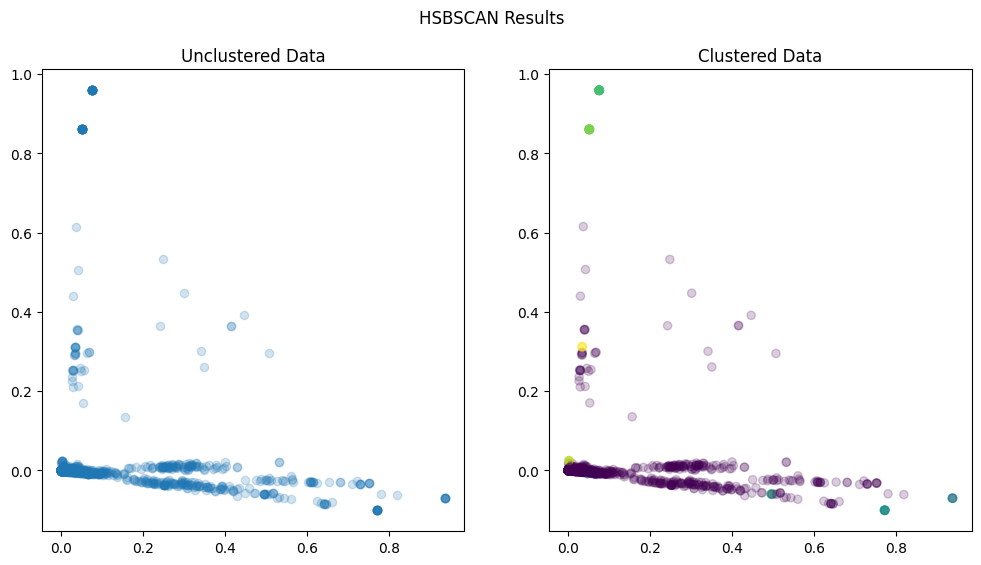

Label: -1
Number of texts in this cluster: 1037
Sample text 1 (Index: 1092 ): and if nothing looks like it is going to come crashing down
Sample text 2 (Index: 879 ): getting real tired of getting shat on by spongey moths
Sample text 3 (Index: 921 ): gave some directions to other swimming options
Sample text 4 (Index: 424 ): 4 in closed cascadilla
Sample text 5 (Index: 1052 ): Saw Josh from the climbing wall and Emily at the start of her shift!
----------------------------
Label: 0
Number of texts in this cluster: 25
Sample text 1 (Index: 196 ): none
Sample text 2 (Index: 896 ): otherwise
Sample text 3 (Index: 250 ): none
Sample text 4 (Index: 1024 ): too
Sample text 5 (Index: 928 ): also
----------------------------
Label: 1
Number of texts in this cluster: 8
Sample text 1 (Index: 349 ): one dog off leash
Sample text 2 (Index: 413 ): one dog off leash
Sample text 3 (Index: 249 ): 1 off leash dog
Sample text 4 (Index: 420 ): 1 dog off leash
Sample text 5 (Index: 127 ): dog off leash
--

In [205]:
inter_hdv_pred = DBSCAN().fit_predict(inter_vectors.toarray())

print("HDBSCAN Clustering Labels Shape:", inter_hdv_pred.shape)

plot_compare(inter_vectors, inter_hdv_pred, "HSBSCAN Results")

pull_samples(inter, inter_hdv_pred, n=5)


### Violations

#### Create Violations Label

In [335]:
# add the cluster number as a dict key pair in interactions
for i, cluster in enumerate(inter_pred_3):
  if cluster == 1:
    interactions_unsplit[i]['violation_label'] = False
  else:
    interactions_unsplit[i]['violation_label'] = True
  if cluster == 2:
    interactions_unsplit[i]['casc_label'] = True
  else:
    interactions_unsplit[i]['casc_label'] = False

violation_count = 0
print("Violations sample:")
for interaction in interactions_unsplit:
  if interaction['violation_label'] == True:
    violation_count += 1
    if violation_count <= 5:
      print(interaction['msg'])

print('---')
no_vio_count = 0
print("No violations sample:")
for interaction in interactions_unsplit:
  if interaction['violation_label'] == False:
    no_vio_count += 1
    if no_vio_count <= 5:
     print(interaction['msg'])

print('---')
casc_count = 0
print("Casc sample:")
for interaction in interactions_unsplit:
  if interaction['casc_label'] == True:
    casc_count += 1
    if casc_count <= 5:
      print(interaction['msg'])

print('---')
print("Number of violations:", violation_count)
print("Number of no violations:", no_vio_count)
print("Number of casc violations:", casc_count)


Violations sample:
Someone asked about north campus
lots of commencement direction questions
few people suntanning on rocks in the water
Lots of people looking for arboretum, three dogs off leash on Bebee Lake trail and Cascadilla Trail. 2 people past trail in Hemlock Gorge
Big day for tourists, small day for violators
---
No violations sample:
no interactions today
no major interactions, only about an hour of no rain
No violations today.
No violations today.
No violations today.
---
Casc sample:
Lots of people looking for arboretum, three dogs off leash on Bebee Lake trail and Cascadilla Trail. 2 people past trail in Hemlock Gorge
1 dog off leash on upper casc
Four guys taking photos in lower Casc
fly fisher in Fall Creek (by Risley); dipping toes in prohibited part of casc; 2 swimmers in beebe; 3 people under suspension bridge
mentally disabled woman did not want to leave spot in casc, took two trys, lady with dog left when asked also in casc
---
Number of violations: 238
Number of n

#### K-Means

310
Shape of clustered interactions: (310,)


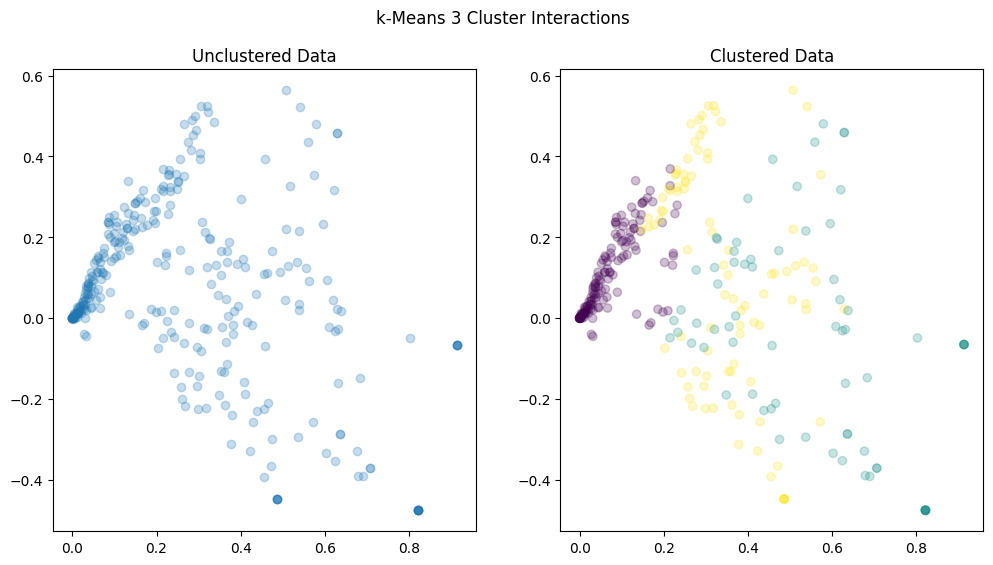

Label: 0
Number of texts in this cluster: 144
Sample text 1 (Index: 33 ): person taking pick below suspension bridge. person fishing above bebe lake goarge.
Sample text 2 (Index: 255 ): Caught out in the storm and enjoyed doing Lightning Drill with Caroline Campbell at Bebee
Sample text 3 (Index: 94 ): none
Sample text 4 (Index: 257 ): Tree down on fence. North rim Fall Creek, right by tennis courts, west of Risley.
Sample text 5 (Index: 214 ): No violations today. Helped an old couple find gorges and hikes!; told two students planning to find Ezra's tunnel about the dangers of swimming in the gorges while they were on Stewart Ave Bridge
Sample text 6 (Index: 296 ): cleared some trails from fallen branches after thunderstorm/flash flood in the morning
Sample text 7 (Index: 285 ): Hole in the pavement on the path to the right when coming from Triphammer Foot Bridge
Sample text 8 (Index: 120 ): howdeedo all the way
Sample text 9 (Index: 235 ): 2 students swimming in hemlock gorge
Sample 

In [79]:
violations = []

for interaction in interactions:
  if interaction['violation_label'] == True:
    violations.append(interaction)

print(len(violations))

vio = []
for violation in violations:
  vio.append(violation['msg'])

vio_tokens = tfidf_vectorizer.fit_transform(vio)

# k-means 3 cluster
vio_pred_3 = KMeans(n_clusters=3, n_init='auto').fit_predict(vio_tokens)
print("Shape of clustered interactions:", vio_pred_3.shape)
plot_compare(vio_tokens, vio_pred_3, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(vio, vio_pred_3, 10)

DBSCAN

DBSCAN Clustering Labels Shape: (310,)


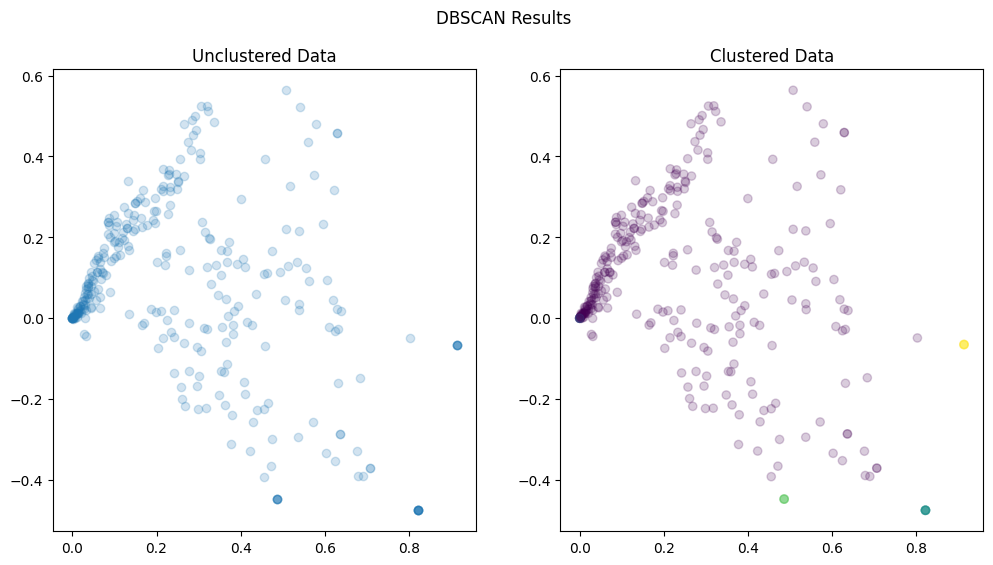

Label: -1
Number of texts in this cluster: 284
Sample text 1 (Index: 5 ): 1 dog off leash on upper casc
Sample text 2 (Index: 40 ): Four people off trail is cascadilla, two at the bottom, 2 at the top
Sample text 3 (Index: 229 ): No violations. Helped a family find Beebe Lake from the cascadilla gorge
Sample text 4 (Index: 144 ): got to pet a dog
Sample text 5 (Index: 219 ): Two people "clif jumping" into the yellow mush in hemlock gorge (gag).
----------------------------
Label: 0
Number of texts in this cluster: 8
Sample text 1 (Index: 96 ): none
Sample text 2 (Index: 155 ): none
Sample text 3 (Index: 94 ): none
Sample text 4 (Index: 22 ): none
Sample text 5 (Index: 71 ): none
----------------------------
Label: 1
Number of texts in this cluster: 8
Sample text 1 (Index: 150 ): all off trail in casc
Sample text 2 (Index: 139 ): off trail in casc
Sample text 3 (Index: 118 ): off trail in casc
Sample text 4 (Index: 168 ): all off trail in casc
Sample text 5 (Index: 156 ): off trail in c

In [80]:
vio_tokens = tfidf_vectorizer.fit_transform(vio)

vio_hdv_pred = DBSCAN().fit_predict(vio_tokens.toarray())

print("DBSCAN Clustering Labels Shape:", vio_hdv_pred.shape)

plot_compare(vio_tokens, vio_hdv_pred, "DBSCAN Results")

pull_samples(vio, vio_hdv_pred, n=5)

### Observations

#### K-Means

Shape of clustered interactions: (223,)


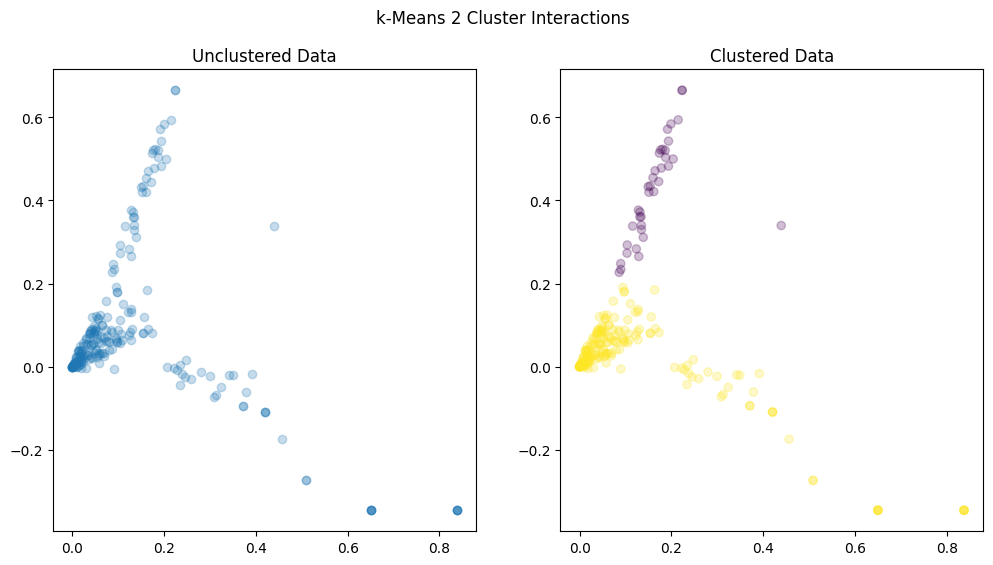

Label: 0
Number of texts in this cluster: 37
Sample text 1 (Index: 46 ): Saw a guy wearing dark-colored rain pants on this 84 degree day when there was full sun. I couldn't have handled that heat.
Sample text 2 (Index: 184 ): Saw a tree down in Cascadilla Gorge
Sample text 3 (Index: 202 ): Near marker BT-114 there is a dead animal (groundhog?) floating next to shore... saw him last week but couldn't tell if it was a rock/something that is always there. Now it's decaying and smelly.
Sample text 4 (Index: 161 ): Talked to a family from Alabama and another family from California, and saw a bunch of chipmunks. 
Sample text 5 (Index: 65 ): I saw a cool butterfly loafing around upper casc
----------------------------
Label: 1
Number of texts in this cluster: 186
Sample text 1 (Index: 160 ): I helped a lost couple find triphammer falls. Someone vomitted their chili onto the wobbly footbridge connecting West campus with Cayuga Heights
Sample text 2 (Index: 69 ): took out some trash
Sample text

In [25]:
# k-Means clustering with n_clusters = 2
obsv = []
for observation in observations:
  obsv.append(observation['msg'])

obsv_vectors = tfidf_vectorizer.fit_transform(obsv)

obsv_pred_2 = KMeans(n_clusters=2, n_init='auto').fit_predict(obsv_vectors)
print("Shape of clustered interactions:", obsv_pred_2.shape)
plot_compare(obsv_vectors, obsv_pred_2, "k-Means 2 Cluster Interactions", alpha = 0.25)

pull_samples(obsv, obsv_pred_2, 5)

#### DBSCAN

DBSCAN Clustering Labels Shape: (223,)


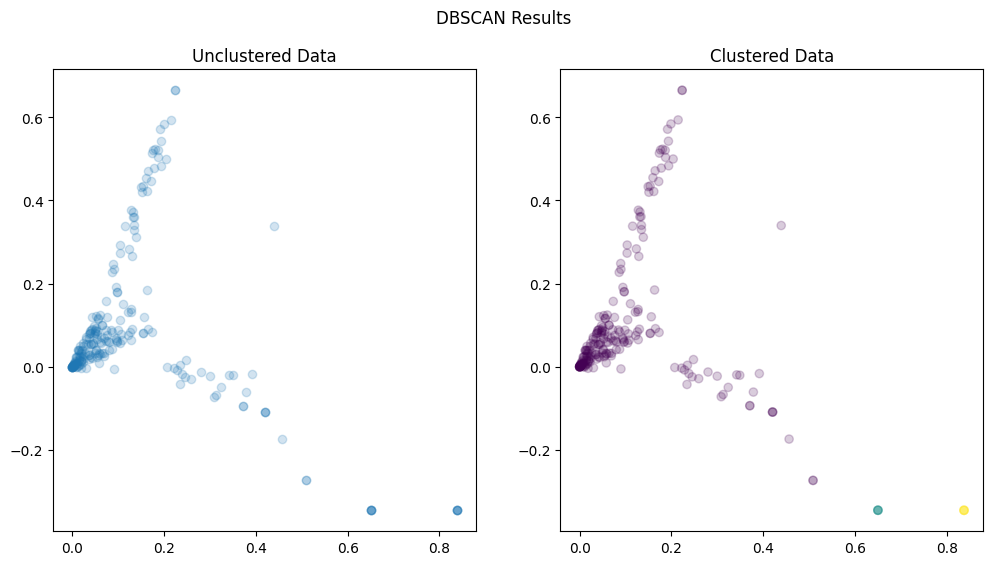

Label: -1
Number of texts in this cluster: 213
Sample text 1 (Index: 122 ): got ice cream, saw snake
Sample text 2 (Index: 160 ): I helped a lost couple find triphammer falls. Someone vomitted their chili onto the wobbly footbridge connecting West campus with Cayuga Heights
Sample text 3 (Index: 202 ): Near marker BT-114 there is a dead animal (groundhog?) floating next to shore... saw him last week but couldn't tell if it was a rock/something that is always there. Now it's decaying and smelly.
Sample text 4 (Index: 147 ): Found Cascadilla fencing displaced
Sample text 5 (Index: 205 ): Such a great day and then rainy nd colder and not so great :(.
----------------------------
Label: 0
Number of texts in this cluster: 5
Sample text 1 (Index: 203 ): Nothing notable.
Sample text 2 (Index: 178 ): Nothing notable.
Sample text 3 (Index: 175 ): Nothing notable.
Sample text 4 (Index: 197 ): Nothing notable.
Sample text 5 (Index: 194 ): Nothing notable.
----------------------------
Label: 1
Num

In [31]:
obsv_hdv_pred = DBSCAN().fit_predict(obsv_vectors.toarray())

print("DBSCAN Clustering Labels Shape:", obsv_hdv_pred.shape)

plot_compare(obsv_vectors, obsv_hdv_pred, "DBSCAN Results")

pull_samples(obsv, obsv_hdv_pred, n=5)

## Classification

#### Labelling

In [339]:
inter_tokenized = []
for inter in interactions_unsplit:
  inter_tokenized.append(nltk.word_tokenize(inter['msg']))

violation_labels = ['no violation', 'casc', 'other']

steward_labels = []
for interaction in interactions_unsplit:
  steward = interaction['steward']
  if steward not in steward_labels:
    steward_labels.append(steward)

year_labels = []
for interaction in interactions_unsplit:
  year = str(interaction['date']).split('-')[0]
  if year not in year_labels:
    year_labels.append(year)

In [340]:
false_positives = [0, 1, 4, 6, 8, 10, 11, 19, 22, 24, 27, 32, 39, 42, 49, 50, 57, 61, 62, 65, 69, 71, 78, 79, 81, 87, 93, 94, 95, 96, 104, 105, 107, 109, 115, 120, 144, 148, 155, 157, 171, 184, 198, 220, 226, 236, 242, 256, 299, 301,296, 295,294, 311, 314, 316, 317, 318, 319, 320, 322, 323, 324, 325, 326]
for interaction in interactions_unsplit:
  if interaction['index'] in false_positives:
    interaction['violation_label'] = False
    print(interaction['msg'])

Someone asked about north campus
lots of commencement direction questions
Big day for tourists, small day for violators
Four guys taking photos in lower Casc
not many people put and about today
1st interaction to give directions, 2nd interaction was to take a picture for a group
directions from suspension bridge
Didn't talk to anyone
none
N/A I don't think many people were out because it was supposed to rain
I helped an elderly couple find the easiest way out of the trail (they were worried about the incline) and informed someone about the partial closing of casc
took pictures for a family
elderly man told his wife to stay out of my way because I am staff
It started pouring by the time I got to casc, mostly people hurrying out at that point
gave someone directions to beebe lake
Everyone was happily minding their own cloudy day on the gorges today
no one looking to break rules or chat today
everyone loves that rock in casc
water was really flowing which inspired attempts to climb waterf

In [350]:
interactions_resplit = []
for interaction in interactions_unsplit:
    parts = re.split(r'[.,;\n]', interaction['msg'])
    for part in parts:
        part = part.strip()
        if part:
            new_inter = interaction.copy()
            new_inter['msg'] = part
            interactions_resplit.append(new_inter)

interactions_df = pd.DataFrame(interactions_resplit)

In [351]:
# vectorize
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    use_idf=False,
)

inter_feats = tfidf_vectorizer.fit_transform(interactions_df['msg'])

print("Feature matrix shape:", inter_feats.shape)

# X_reduced = TruncatedSVD().fit_transform(features)
# sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=inters, alpha=0.02)
# plt.show()


Feature matrix shape: (591, 801)


In [352]:
print('Total interactions:',len(interactions_df))
print('number of violations:', len(interactions_df[interactions_df['violation_label'] == True]))
print('number of non-violations:', len(interactions_df[interactions_df['violation_label'] == False]))
print('interactions dataframe')
interactions_df.head()


Total interactions: 591
number of violations: 527
number of non-violations: 64
interactions dataframe


,index,date,steward,msg,violation_label,casc_label
0,0,2023-05-25,Brenner,Someone asked about north campus,False,False
1,1,2023-05-26,Brenner,lots of commencement direction questions,False,False
2,2,2023-05-27,Brenner,few people suntanning on rocks in the water,True,False
3,3,2023-05-28,Phillip,Lots of people looking for arboretum,True,True
4,3,2023-05-28,Phillip,three dogs off leash on Bebee Lake trail and C...,True,True


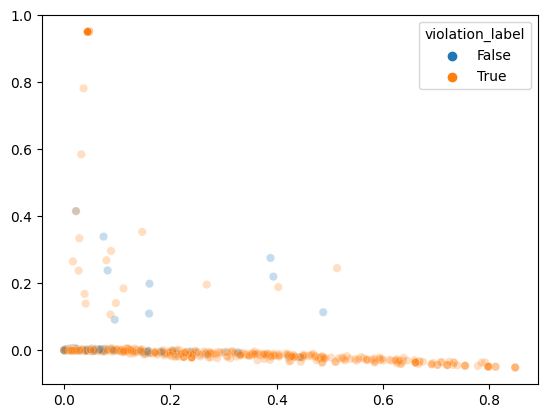

In [353]:
X_reduced = TruncatedSVD().fit_transform(inter_feats)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=interactions_df['violation_label'], alpha=0.25)
plt.show()

In [349]:
%%time
# fit and score the same classifiers as above
# scoring (with cross validation)
print(f"\nkNN score, cross validated:   {np.mean(cross_val_score(knn_clf, features, breadmeat['recipe_class'])):.3f}")
print(f"Logit score, cross validated: {np.mean(cross_val_score(logit_clf, features, breadmeat['recipe_class'])):.3f}")
print(f"SVM score, cross validated:   {np.mean(cross_val_score(svm_clf, features, breadmeat['recipe_class'])):.3f}")

NameError: ignored